# On movement algorithms

_author: Tyler Coles_

Our movement processing works by taking sequential multivariate hypergeometric (mvhg) draws on a diminishing pool. Is this statistically correct?

Because we process locations in a fixed order and locations may have drastically different numbers of movers, it's unclear to me if this could be skewing the chances that later/smaller populations receive individuals from certain compartments. In other words, do large movement vectors drain the pool of infecteds before smaller populations get a chance? (Especially when there's a relatively small number of infected individuals.)

Let's test this experimentally.

## Experiment setup

Let's take a simplified example world with four populations: $a$, $b$, $c$, and $d$. Population $a$ will have one million people total with one thousand infected in a standard SIR model. In a normal movement cycle, ten thousand people go to $b$, and one hundred each go to $c$ and $d$.

Defining a "successful" trial as an infected individual moving from $a$ to $d$, we can use the hypergeometric probability formula to calculate the expected odds of certain numbers of successes (we are sampling without replacement):

$$P(X = k) = \frac{\binom{K}{k} \binom{N - K}{n-k}}{\binom{N}{n}}$$

If our movement model is fair (not skewed) we should see similar experimental results (for a large number of random trials).


In [1]:
import math

# size of the population
N = 1_000_000
# number of infected
K = 1_000


def prob(k: int, n: int) -> float:
    """hypergeometric distributed probability of k successes in n trials"""
    return math.comb(K, k) * math.comb(N - K, n - k) / math.comb(N, n)


probs = [prob(k, 100) for k in range(0, 10)]

for k, p in enumerate(probs):
    print(f"P(X = {k}) = {p:>7.3%}")
print(" ...etc...")
print(f"P(X ≥ 1) = {(1 - probs[0]):>7.3%}")

P(X = 0) = 90.479%
P(X = 1) =  9.058%
P(X = 2) =  0.448%
P(X = 3) =  0.015%
P(X = 4) =  0.000%
P(X = 5) =  0.000%
P(X = 6) =  0.000%
P(X = 7) =  0.000%
P(X = 8) =  0.000%
P(X = 9) =  0.000%
 ...etc...
P(X ≥ 1) =  9.521%


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator

# [S,I,R] compartments in a
pop_a = np.array([N - K, K, 0], dtype=int)

# we have pops [a,b,c,d]
# number of movers from a to [a,b,c,d]
mov_a = np.array([0, 10_000, 100, 100], dtype=int)

total_movers = sum(mov_a)

# normalized number of movers leaving
# (aka, the probability that any given mover would go to a particular destination)
mover_ps = mov_a / total_movers


def run_trials(movement_func, trials):
    """exercise the given movement function a bunch of times then aggregate and display the results"""
    rng = np.random.default_rng(1)

    # collect the number of "successes":
    # individuals moving from pop_1 (the first population) to pop_n (the last population) who are infected
    res = np.fromiter((movement_func(rng)
                      for _ in range(trials)), dtype=int, count=trials)

    # count how many times each result happens and plot as bar chart
    values, occurrences = np.unique(res, return_counts=True)
    plt.bar(values, occurrences / trials)
    plt.title('P(x infected movers from pop_1 to pop_n)')
    plt.ylim((0, 1))
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.show()

    # print the observed probability of each outcome
    for value, occurs in zip(values, occurrences):
        print(f"Pr(X = {value}): {(occurs / trials):>7.3%}")


TRIALS = 10_000_000

### Movement Scheme #1

This movement scheme is roughly representative of our current algorithm.

For each destination in sequence:

1. perform a mvhg draw to select the individuals going to that destination,
2. decrement the selected individuals from the source pool, and
3. repeat.


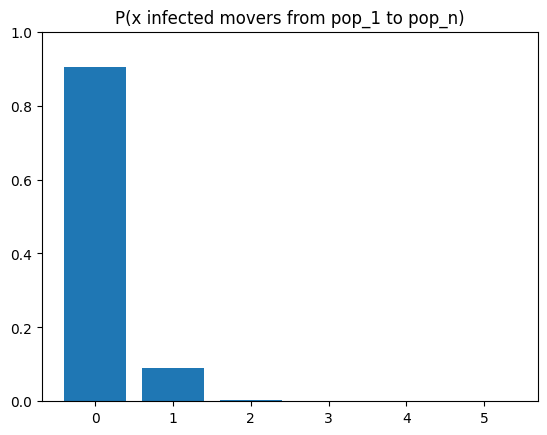

Pr(X = 0): 90.474%
Pr(X = 1):  9.063%
Pr(X = 2):  0.448%
Pr(X = 3):  0.015%
Pr(X = 4):  0.000%
Pr(X = 5):  0.000%


In [3]:
def movement_1(rng: Generator) -> int:
    a = pop_a.copy()
    a -= rng.multivariate_hypergeometric(a, mov_a[0])
    a -= rng.multivariate_hypergeometric(a, mov_a[1])
    a_to_d = rng.multivariate_hypergeometric(a, mov_a[2])
    # return number of I going to d
    return a_to_d[1]


run_trials(movement_1, TRIALS)

### Movement Scheme #2

This movement scheme is a slightly different approach.

1. Perform one mvhg draw to select every individual leaving from $a$, then
2. distribute those individuals between all destinations using a multinomial draw for each compartment based on the destination's
probability.


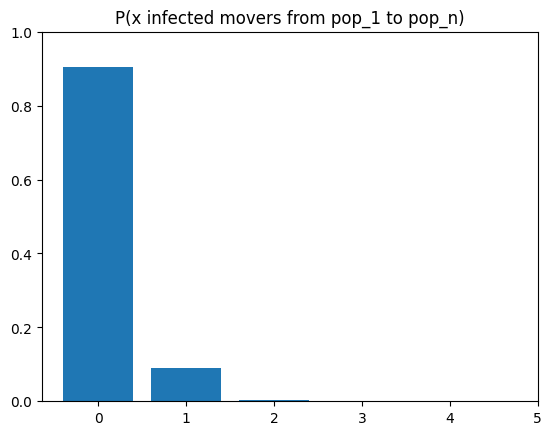

Pr(X = 0): 90.483%
Pr(X = 1):  9.047%
Pr(X = 2):  0.454%
Pr(X = 3):  0.016%
Pr(X = 4):  0.000%


In [4]:
def movement_2(rng: Generator) -> int:
    a = pop_a.copy()  # this is only here to make runtime fairly comparable to movement_1

    mover_cs = rng.multivariate_hypergeometric(pop_a, total_movers)
    split_cs = rng.multinomial(mover_cs, mover_ps).T
    # return number of I going to d
    return split_cs[2, 1]


run_trials(movement_2, TRIALS)

### Statistical Results

Both movement schemes reproduce our expectations! There is no obvious statistical difference between the two.

## Runtime Analysis

In terms of runtime, however, scheme #2 appears to have a small edge. But if we run this with 1000 populations instead, the performance difference is stark!

In [5]:
import time

# [S,I,R] compartments in A
N = 10_000_000
K = 10_000
pop_a = np.array([N - K, K, 0], dtype=int)

# we have 1000 pops, the last one is called Z
# number of movers from A to all other pops
# - the first entry is A itself
# - then 10 pops with 1000 movers
# - then the rest with 100 movers
mov_a = np.concatenate((
    np.array([0], dtype=int),
    np.full(shape=(10,), fill_value=1000, dtype=int),
    np.full(shape=(989,), fill_value=100, dtype=int),
))

total_movers = sum(mov_a)

# normalized number of movers leaving
# (aka, the probability that any given mover would go to a particular destination)
mover_ps = mov_a / total_movers


def prob(k: int, n: int) -> float:
    """hypergeometric distributed probability of k successes in n trials"""
    return math.comb(K, k) * math.comb(N - K, n - k) / math.comb(N, n)


display("Double-checking since we changed the population numbers:")
display(f"P(X ≥ 1) = {(1 - prob(0,100)):>7.3%}")

TRIALS_PART_B = 10_000

'Double-checking since we changed the population numbers:'

'P(X ≥ 1) =  9.521%'

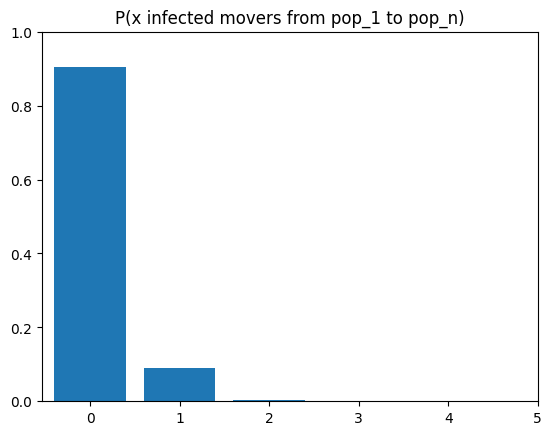

Pr(X = 0): 90.530%
Pr(X = 1):  9.100%
Pr(X = 2):  0.370%


'Runtime: 96.355s'

In [6]:
def movement_1b(rng: Generator) -> int:
    a = pop_a.copy()
    last = np.zeros(3, dtype=int)
    for movers in mov_a:
        last = rng.multivariate_hypergeometric(a, movers)
        a -= last
    return last[1]


t0 = time.perf_counter()
run_trials(movement_1b, TRIALS_PART_B)
t1 = time.perf_counter()
f"Runtime: {(t1 - t0):.3f}s"

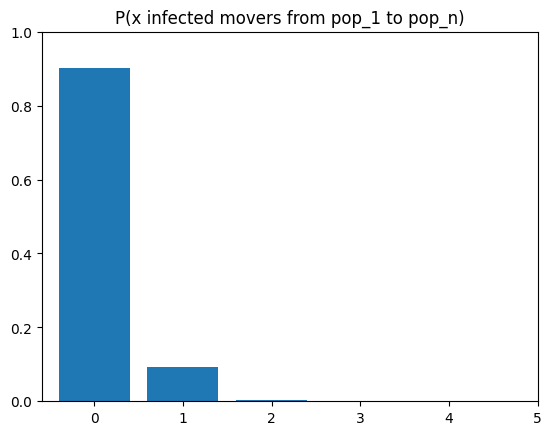

Pr(X = 0): 90.240%
Pr(X = 1):  9.280%
Pr(X = 2):  0.460%
Pr(X = 3):  0.020%


'Runtime: 1.314s'

In [7]:
def movement_2b(rng: Generator) -> int:
    a = pop_a.copy()  # this is only here to make runtime fairly comparable to movement_1
    mover_cs = rng.multivariate_hypergeometric(pop_a, total_movers)
    split_cs = rng.multinomial(mover_cs, mover_ps).T
    return split_cs[-1, 1]


t0 = time.perf_counter()
run_trials(movement_2b, TRIALS_PART_B)
t1 = time.perf_counter()
f"Runtime: {(t1 - t0):.3f}s"

## Conclusion

These results strongly suggest that the order in which we process locations during movement does not matter!